<a href="https://colab.research.google.com/github/Nicolasalan/td3/blob/main/vault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
!nvidia-smi

Sat Oct 28 17:12:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Adicionar script ao console desse navegador: `inspecionar` => `console` => `adicionar script`.
```
function ConnectButton(){
    console.log("Conectado");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
```

# **Install**

In [2]:
!sudo apt-get install swig

!pip install gymnasium
!pip install gymnasium[box2d]

!pip install torch
!pip install matplotlib
!pip install numpy
!pip install wandb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (515 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
de

# **TD3 - Twin Delayed DDPG**

In [ ]:
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple, deque
from numpy import inf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 100        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
UPDATE_EVERY_STEP = 2   # how often to update the target and actor networks
SIGMA = 0
THETA = 0
L1 = 0
L2 = 0
dropout = 0
BatchNorm1d = 0
lstm_dim = 0
WEIGHT_DECAY = 0
LEARN_EVERY = 0         # learning timestep interval
LEARN_NUM = 0           # number of learning passes

EPSILON = 0             # explore->exploit noise process added to act step #######
EPSILON_DECAY = 0       # decay rate for noise process

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **🔒Replay Buffer**

https://github.com/gribeiro2004/Continuous-control-with-DDPG-and-prioritized-experience-replay

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### **💡Model**

In [ ]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, max_action, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): the maximum valid value for action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

    def add_parameter_noise(self, scalar=0.1):
        for layer in [self.fc1, self.fc2, self.fc3]:
            layer.weight.data += torch.randn_like(layer.weight.data) * scalar

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, l1=400, l2=300):
        super(Critic, self).__init__()

    # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, 1)

    # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, l1)
        self.l5 = nn.Linear(l1, l2)
        self.l6 = nn.Linear(l2, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2


### **🚀Agent**

In [ ]:
class TD3Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, max_action, min_action, random_seed, target_noise=0.2, noise_std=0.1, noise_clip=0.5):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            max_action (ndarray): the maximum valid value for each action vector
            min_action (ndarray): the minimum valid value for each action vector
            random_seed (int): random seed
            noise (float): the range to generate random noise while learning
            noise_std (float): the range to generate random noise while performing action
            noise_clip (float): to clip random noise into this range
        """

        self.state_size = state_size
        self.action_size = action_size
        self.max_action = max_action
        self.min_action = min_action
        self.noise_std = noise_std
        self.noise_clip = noise_clip
        self.target_noise = target_noise
        self.seed = random.seed(random_seed)

        print(random.seed(random_seed))

        # parameter noise
        self.distances = []
        self.desired_distance = 0.2
        self.scalar = 0.05
        self.scalar_decay = 0.99

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, float(max_action[0])).to(device)
        self.actor_target = Actor(state_size, action_size, float(max_action[0])).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_target.load_state_dict(self.critic_local.state_dict())
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)

        self.actor_noise = Actor(state_size, action_size, float(max_action[0])).to(device)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory"""
        # Save experience / reward
        if isinstance(state, np.ndarray):
            states = state
        elif isinstance(state, tuple):
            states = np.array(state[0], dtype=np.float32)

        self.memory.add(states, action, reward, next_state, done)

    def predict(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        # Verificando se é uma numpy.ndarray
        if isinstance(states, np.ndarray):
            convert_state = states
        elif isinstance(states, tuple):
            convert_state = np.array(states[0], dtype=np.float32)
        state = torch.from_numpy(convert_state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()

        if add_noise:
            # Generate a random noise
            self.actor_noise.load_state_dict(self.actor_local.state_dict().copy())
            self.actor_noise.add_parameter_noise(self.scalar)
            action_noise = self.actor_noise(state).cpu().data.numpy()
            distance = np.sqrt(np.mean(np.square(action - action_noise)))
            self.distances.append(distance)

            if distance > self.desired_distance:
                self.scalar *= self.scalar_decay
            if distance < self.desired_distance:
                self.scalar /= self.scalar_decay

            #action = action_noise

        self.actor_local.train()

        return np.clip(action, self.min_action[0], self.max_action[0]), np.mean(action_noise)

    def learn(self, n_iteraion, gamma=GAMMA):
        """Update policy and value parameters using given batch of experience tuples.

        Params
        ======
            n_iteraion (int): the number of iterations to train network
            gamma (float): discount factor
        """

        if len(self.memory) > BATCH_SIZE:

            av_Q = 0
            max_Q = -inf
            av_loss = 0

            for i in range(n_iteraion):
                state, action, reward, next_state, done = self.memory.sample()

                action_ = action.cpu().numpy()

                # ---------------------------- update critic ---------------------------- #
                # Get predicted next-state actions and Q values from target models
                actions_next = self.actor_target(next_state)

                # Generate a random noise
                noise = torch.FloatTensor(action_).data.normal_(0, self.target_noise).to(device)
                noise = noise.clamp(-self.noise_clip, self.noise_clip)
                actions_next = (actions_next + noise).clamp(self.min_action[0].astype(float), self.max_action[0].astype(float))

                Q1_targets_next, Q2_targets_next = self.critic_target(next_state, actions_next)

                Q_targets_next = torch.min(Q1_targets_next, Q2_targets_next)

                av_Q += torch.mean(Q_targets_next)
                max_Q = max(max_Q, torch.max(Q_targets_next))

                # Compute Q targets for current states (y_i)
                Q_targets = reward + (gamma * Q_targets_next * (1 - done)).detach()
                # Compute critic loss
                Q1_expected, Q2_expected = self.critic_local(state, action)
                critic_loss = F.mse_loss(Q1_expected, Q_targets) + F.mse_loss(Q2_expected, Q_targets)

                # Minimize the loss
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                if i % UPDATE_EVERY_STEP == 0:
                    # ---------------------------- update actor ---------------------------- #
                    # Compute actor loss
                    actor_loss, _ = self.critic_local(state, self.actor_local(state))
                    actor_loss = -actor_loss.mean()
                    # Minimize the loss
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()

                    # ----------------------- update target networks ----------------------- #
                    self.soft_update(self.critic_local, self.critic_target, TAU)
                    self.soft_update(self.actor_local, self.actor_target, TAU)

                av_loss += critic_loss

            # Write new values
            loss = av_loss / n_iteraion
            av = av_Q / n_iteraion
            max_policy = max_Q

            return [loss, av, max_policy]


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


## **📌Env**

### **BipedalWalker**

#### **Gym**

In [ ]:
import gymnasium as gym
env = gym.make("BipedalWalker-v3", hardcore=True)

# tamanho de cada ação
action_size = env.action_space
print('Tamanho de cada ação:', action_size.shape[0])

# vínculo superior de cada ação
upper_bond = env.action_space.high
print('Ligação superior de cada ação:', upper_bond[0])

# vínculo inferior de cada ação
lower_bond = env.action_space.low
print('Ligação inferior de cada ação:', lower_bond[0])

#examina o espaço de estados
states = env.observation_space
state_size = states.shape[0]
print('Cada um observa um estado com comprimento: {}'.format(state_size))

agent = TD3Agent(state_size=env.observation_space.shape[0], \
                 action_size=env.action_space.shape[0], \
                 max_action=env.action_space.high, \
                 min_action=env.action_space.low, random_seed=42)

Tamanho de cada ação: 4
Ligação superior de cada ação: 1.0
Ligação inferior de cada ação: -1.0
Cada um observa um estado com comprimento: 24
None


#### **Train**

In [ ]:
def td3(n_episodes=1000, max_t=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action, noise = agent.predict(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done or t==(max_t-1):
                loss, av_q, max_q = agent.learn(t)
                break

        scores_deque.append(score)
        scores.append(score)
        mean_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f} | \tScore: {:.2f} | \tLoss: {:.2f} | \tAv. Q: {:.2f} | \tMax. Q: {:.2f} | \tAverage Noise: {:.2f} | \tAverage Action: {:.2f}'.format(i_episode, mean_score, score, loss, av_q, max_q, noise, np.mean(action)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} | \tLoss: {:.2f} | \tAv. Q: {:.2f} | \tMax. Q: {:.2f}'.format(i_episode, mean_score,loss, av_q, max_q))
        if mean_score >= 300 and solved == False:
            print('\rSolved at Episode {} !\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            solved = True

    return scores

scores = td3()

#### **Plot**

Text(0.5, 0, 'Episode #')

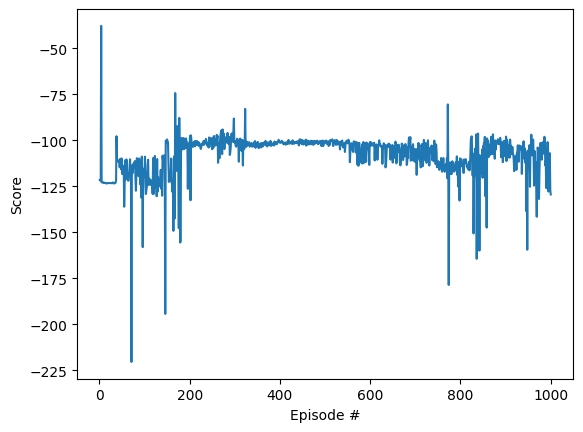

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

#### **Result**

In [ ]:
# Instalações para ver o agente
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth'))
agent.critic_local.load_state_dict(torch.load('critic_checkpoint.pth'))

env = gym.make('BipedalWalker-v3')
state = env.reset()
score = 0
img = plt.imshow(env.render('rgb_array'))
while True:
    img.set_data(env.render('rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = agent.predict(state)
    next_state, reward, done, _, _ = env.step(action)
    state = next_state
    score += reward
    if np.any(done):
        break

print("Score: {}".format(score))

### **Custom Env**

In [ ]:
import pygame
import math

screen_width = 1500
screen_height = 800
check_point = ((1200, 660), (1250, 120), (190, 200), (1030, 270), (250, 475), (650, 690))

class Car:
    def __init__(self, car_file, map_file, pos):
        self.surface = pygame.image.load(car_file)
        self.map = pygame.image.load(map_file)
        self.surface = pygame.transform.scale(self.surface, (100, 100))
        self.rotate_surface = self.surface
        self.pos = pos
        self.angle = 0
        self.speed = 0
        self.center = [self.pos[0] + 50, self.pos[1] + 50]
        self.radars = []
        self.radars_for_draw = []
        self.is_alive = True
        self.current_check = 0
        self.prev_distance = 0
        self.cur_distance = 0
        self.goal = False
        self.check_flag = False
        self.distance = 0
        self.time_spent = 0
        for d in range(-90, 120, 45):
            self.check_radar(d)

        for d in range(-90, 120, 45):
            self.check_radar_for_draw(d)

    def draw(self, screen):
        screen.blit(self.rotate_surface, self.pos)

    def draw_collision(self, screen):
        for i in range(4):
            x = int(self.four_points[i][0])
            y = int(self.four_points[i][1])
            pygame.draw.circle(screen, (255, 255, 255), (x, y), 5)

    def draw_radar(self, screen):
        for r in self.radars_for_draw:
            pos, dist = r
            pygame.draw.line(screen, (0, 255, 0), self.center, pos, 1)
            pygame.draw.circle(screen, (0, 255, 0), pos, 5)

    def check_collision(self):
        self.is_alive = True
        for p in self.four_points:
            if self.map.get_at((int(p[0]), int(p[1]))) == (255, 255, 255, 255):
                self.is_alive = False
                break

    def check_radar(self, degree):
        len = 0
        x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * len)
        y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * len)

        while not self.map.get_at((x, y)) == (255, 255, 255, 255) and len < 300:
            len = len + 1
            x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * len)
            y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * len)

        dist = int(math.sqrt(math.pow(x - self.center[0], 2) + math.pow(y - self.center[1], 2)))
        self.radars.append([(x, y), dist])


    def check_radar_for_draw(self, degree):
        len = 0
        x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * len)
        y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * len)

        while not self.map.get_at((x, y)) == (255, 255, 255, 255) and len < 300:
            len = len + 1
            x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * len)
            y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * len)

        dist = int(math.sqrt(math.pow(x - self.center[0], 2) + math.pow(y - self.center[1], 2)))
        self.radars_for_draw.append([(x, y), dist])

    def check_checkpoint(self):
        p = check_point[self.current_check]
        self.prev_distance = self.cur_distance
        dist = get_distance(p, self.center)
        if dist < 70:
            self.current_check += 1
            self.prev_distance = 9999
            self.check_flag = True
            if self.current_check >= len(check_point):
                self.current_check = 0
                self.goal = True
            else:
                self.goal = False

        self.cur_distance = dist

    def update(self):
        #check speed
        self.speed -= 0.5
        if self.speed > 10:
            self.speed = 10
        if self.speed < 1:
            self.speed = 1

        #check position
        self.rotate_surface = rot_center(self.surface, self.angle)
        self.pos[0] += math.cos(math.radians(360 - self.angle)) * self.speed
        if self.pos[0] < 20:
            self.pos[0] = 20
        elif self.pos[0] > screen_width - 120:
            self.pos[0] = screen_width - 120

        self.distance += self.speed
        self.time_spent += 1
        self.pos[1] += math.sin(math.radians(360 - self.angle)) * self.speed
        if self.pos[1] < 20:
            self.pos[1] = 20
        elif self.pos[1] > screen_height - 120:
            self.pos[1] = screen_height - 120

        # caculate 4 collision points
        self.center = [int(self.pos[0]) + 50, int(self.pos[1]) + 50]
        len = 40
        left_top = [self.center[0] + math.cos(math.radians(360 - (self.angle + 30))) * len, self.center[1] + math.sin(math.radians(360 - (self.angle + 30))) * len]
        right_top = [self.center[0] + math.cos(math.radians(360 - (self.angle + 150))) * len, self.center[1] + math.sin(math.radians(360 - (self.angle + 150))) * len]
        left_bottom = [self.center[0] + math.cos(math.radians(360 - (self.angle + 210))) * len, self.center[1] + math.sin(math.radians(360 - (self.angle + 210))) * len]
        right_bottom = [self.center[0] + math.cos(math.radians(360 - (self.angle + 330))) * len, self.center[1] + math.sin(math.radians(360 - (self.angle + 330))) * len]
        self.four_points = [left_top, right_top, left_bottom, right_bottom]

class PyGame2D:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((screen_width, screen_height))
        self.clock = pygame.time.Clock()
        self.font = pygame.font.SysFont("Arial", 30)
        self.car = Car('car.png', 'map.png', [700, 650])
        self.game_speed = 60
        self.mode = 0

    def action(self, action):
        if action == 0:
            self.car.speed += 2
        if action == 1:
            self.car.angle += 5
        elif action == 2:
            self.car.angle -= 5

        self.car.update()
        self.car.check_collision()
        self.car.check_checkpoint()

        self.car.radars.clear()
        for d in range(-90, 120, 45):
            self.car.check_radar(d)

    def evaluate(self):
        reward = 0
        """
        if self.car.check_flag:
            self.car.check_flag = False
            reward = 2000 - self.car.time_spent
            self.car.time_spent = 0
        """
        if not self.car.is_alive:
            reward = -10000 + self.car.distance

        elif self.car.goal:
            reward = 10000
        return reward

    def is_done(self):
        if not self.car.is_alive or self.car.goal:
            self.car.current_check = 0
            self.car.distance = 0
            return True
        return False

    def observe(self):
        # return state
        radars = self.car.radars
        ret = [0, 0, 0, 0, 0]
        for i, r in enumerate(radars):
            ret[i] = int(r[1] / 30)

        return tuple(ret)

    def view(self):
        # draw game
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_m:
                    self.mode += 1
                    self.mode = self.mode % 3

        self.screen.blit(self.car.map, (0, 0))


        if self.mode == 1:
            self.screen.fill((0, 0, 0))

        self.car.radars_for_draw.clear()
        for d in range(-90, 120, 45):
            self.car.check_radar_for_draw(d)

        pygame.draw.circle(self.screen, (255, 255, 0), check_point[self.car.current_check], 70, 1)
        self.car.draw_collision(self.screen)
        self.car.draw_radar(self.screen)
        self.car.draw(self.screen)


        text = self.font.render("Press 'm' to change view mode", True, (255, 255, 0))
        text_rect = text.get_rect()
        text_rect.center = (screen_width/2, 100)
        self.screen.blit(text, text_rect)



        pygame.display.flip()
        self.clock.tick(self.game_speed)


def get_distance(p1, p2):
	return math.sqrt(math.pow((p1[0] - p2[0]), 2) + math.pow((p1[1] - p2[1]), 2))

def rot_center(image, angle):
    orig_rect = image.get_rect()
    rot_image = pygame.transform.rotate(image, angle)
    rot_rect = orig_rect.copy()
    rot_rect.center = rot_image.get_rect().center
    rot_image = rot_image.subsurface(rot_rect).copy()
    return rot_image

import gym
from gym import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        self.pygame = PyGame2D()
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(np.array([0, 0, 0, 0, 0]), np.array([10, 10, 10, 10, 10]), dtype=np.int)

    def reset(self):
        del self.pygame
        self.pygame = PyGame2D()
        obs = self.pygame.observe()
        return obs

    def step(self, action):
        self.pygame.action(action)
        obs = self.pygame.observe()
        reward = self.pygame.evaluate()
        done = self.pygame.is_done()
        return obs, reward, done, {}

    def render(self, mode="human", close=False):
        self.pygame.view()

# **Others RL**

## **TD3 .v1**

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main

In [ ]:
import copy
import os
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [ ]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

In [ ]:
class GaussianNoise:
    """Gaussian Noise.
    Taken from https://github.com/vitchyr/rlkit
    """

    def __init__(
        self,
        action_dim: int,
        min_sigma: float = 1.0,
        max_sigma: float = 1.0,
        decay_period: int = 1000000,
    ):
        """Initialize."""
        self.action_dim = action_dim
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period

    def sample(self, t: int = 0) -> float:
        """Get an action with gaussian noise."""
        sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(
            1.0, t / self.decay_period
        )
        return np.random.normal(0, sigma, size=self.action_dim)

In [ ]:
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action


class Critic(nn.Module):
    def __init__(self, in_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

In [ ]:
class TD3Agent:
    """TD3Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor1 (nn.Module): target actor model to select actions
        actor2 (nn.Module): target actor model to select actions
        actor_target1 (nn.Module): actor model to predict next actions
        actor_target2 (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic1 (nn.Module): critic model to predict state values
        critic2 (nn.Module): critic model to predict state values
        critic_target1 (nn.Module): target critic model to predict state values
        critic_target2 (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        exploration_noise (GaussianNoise): gaussian noise for policy
        target_policy_noise (GaussianNoise): gaussian noise for target policy
        target_policy_noise_clip (float): clip target gaussian noise
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        policy_update_freq (int): update actor every time critic updates this times
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        exploration_noise: float = 0.1,
        target_policy_noise: float = 0.2,
        target_policy_noise_clip: float = 0.5,
        initial_random_steps: int = int(1e4),
        policy_update_freq: int = 2,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.policy_update_freq = policy_update_freq

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # noise
        self.exploration_noise = GaussianNoise(
            action_dim, exploration_noise, exploration_noise
        )
        self.target_policy_noise = GaussianNoise(
            action_dim, target_policy_noise, target_policy_noise
        )
        self.target_policy_noise_clip = target_policy_noise_clip

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic1 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target1 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target1.load_state_dict(self.critic1.state_dict())

        self.critic2 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target2 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target2.load_state_dict(self.critic2.state_dict())

        # concat critic parameters to use one optim
        critic_parameters = list(self.critic1.parameters()) + list(
            self.critic2.parameters()
        )

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(critic_parameters, lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # update step for actor
        self.update_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device))[0]
                .detach()
                .cpu()
                .numpy()
            )

        # add noise for exploration during training
        if not self.is_test:
            noise = self.exploration_noise.sample()
            selected_action = np.clip(
                selected_action + noise, -1.0, 1.0
            )

            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        states = torch.FloatTensor(samples["obs"]).to(device)
        next_states = torch.FloatTensor(samples["next_obs"]).to(device)
        actions = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        rewards = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        dones = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        masks = 1 - dones

        # get actions with noise
        noise = torch.FloatTensor(self.target_policy_noise.sample()).to(device)
        clipped_noise = torch.clamp(
            noise, -self.target_policy_noise_clip, self.target_policy_noise_clip
        )

        next_actions = (self.actor_target(next_states) + clipped_noise).clamp(
            -1.0, 1.0
        )

        # min (Q_1', Q_2')
        next_values1 = self.critic_target1(next_states, next_actions)
        next_values2 = self.critic_target2(next_states, next_actions)
        next_values = torch.min(next_values1, next_values2)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_returns = rewards + self.gamma * next_values * masks
        curr_returns = curr_returns.detach()

        # critic loss
        values1 = self.critic1(states, actions)
        values2 = self.critic2(states, actions)
        critic1_loss = F.mse_loss(values1, curr_returns)
        critic2_loss = F.mse_loss(values2, curr_returns)

        # train critic
        critic_loss = critic1_loss + critic2_loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_step % self.policy_update_freq == 0:
            # train actor
            actor_loss = -self.critic1(states, self.actor(states)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # target update
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(1)

        return actor_loss.data, critic_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)

        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True

        state = self.env.reset()
        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        return frames

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target1.parameters(), self.critic1.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target2.parameters(), self.critic2.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(30, 5))
        plt.subplot(131)
        plt.title("frame %s. score: %s" % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title("actor_loss")
        plt.plot(actor_losses)
        plt.subplot(133)
        plt.title("critic_loss")
        plt.plot(critic_losses)
        plt.show()

In [ ]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [ ]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[777]

In [ ]:
# parameters
num_frames = 100000
memory_size = 100000
batch_size = 128
initial_random_steps = 10000

agent = TD3Agent(
    env, memory_size, batch_size, initial_random_steps=initial_random_steps
)

cpu


In [ ]:
agent.train(num_frames)

KeyboardInterrupt: ignored

## **TD3 .v2**

In [ ]:
import numpy as np
import torch as T

class Buffer:
    def __init__(
        self,
        observationDim: int,
        actionDim: int,
        device: T.device,
        size: int = 1_000_000,
    ):
        self.device = device
        # use a fixed-size buffer to prevent constant list instantiations
        self.states = T.zeros((size, observationDim), device=self.device)
        self.actions = T.zeros((size, actionDim), device=self.device)
        self.rewards = T.zeros(size, device=self.device)
        self.nextStates = T.zeros((size, observationDim), device=self.device)
        self.doneFlags = T.zeros(size, device=self.device)
        # use a pointer to keep track of where in the buffer we are
        self.pointer = 0
        # use current size to ensure we don't train on any non-existent data points
        self.currentSize = 0
        self.size = size

    def store(
        self,
        state: np.ndarray,
        action: np.ndarray,
        reward: float,
        nextState: np.ndarray,
        doneFlag: bool,
    ):
        # store all the data for this transition
        ptr = self.pointer
        tensorState = T.tensor(state, device=self.device)
        tensorAction = T.tensor(action, device=self.device)
        tensorNextState = T.tensor(nextState, device=self.device)
        self.states[ptr, :] = tensorState
        self.actions[ptr, :] = tensorAction
        self.rewards[ptr] = reward
        self.nextStates[ptr, :] = tensorNextState
        self.doneFlags[ptr] = float(doneFlag)
        # update the pointer and current size
        self.pointer = (self.pointer + 1) % self.size
        self.currentSize = min(self.currentSize + 1, self.size)

    def getMiniBatch(self, size: int) -> dict[str, T.Tensor]:
        # ensure size is not bigger than the current size of the buffer
        size = min(size, self.currentSize)
        # generate random indices
        indices = T.randint(0, self.currentSize, (size,), device=self.device)
        # return the mini-batch of transitions
        return {
            "states": self.states[indices, :],
            "actions": self.actions[indices, :],
            "rewards": self.rewards[indices],
            "nextStates": self.nextStates[indices, :],
            "doneFlags": self.doneFlags[indices],
        }

In [ ]:
from typing import Callable
import torch as T
import torch.nn as nn
import torch.optim as optim


class Network(nn.Module):
    def __init__(
        self,
        shape: list,
        outputActivation: Callable,
        learningRate: float,
        device: T.device,
    ):
        super().__init__()
        # initialize the network
        layers = []
        for i in range(1, len(shape)):
            dim1 = shape[i - 1]
            dim2 = shape[i]
            layers.append(nn.Linear(dim1, dim2))
            if i < len(shape) - 1:
                layers.append(nn.ReLU())
        layers.append(outputActivation())
        self.network = nn.Sequential(*layers)

        self.optimizer = optim.Adam(self.parameters(), lr=learningRate)
        self.device = device
        self.to(self.device)

    def forward(self, state: T.Tensor) -> T.Tensor:
        return self.network(state)

    def gradientDescentStep(self, loss: T.Tensor, retainGraph: bool = False) -> None:
        self.optimizer.zero_grad()
        loss.backward(retain_graph=retainGraph)
        self.optimizer.step()

In [ ]:
import numpy as np
import os
import pickle
import torch as T
import torch.nn as nn
from copy import deepcopy
from gymnasium.core import Env


class Agent:
    def __init__(
        self,
        env: Env,
        learningRate: float,
        gamma: float,
        tau: float,
        shouldLoad: bool = True,
        saveFolder: str = "saved",
    ):
        self.observationDim = env.observation_space.shape[0]
        self.actionDim = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        # check if the saveFolder path exists
        if not os.path.isdir(saveFolder):
            os.mkdir(saveFolder)
        self.envName = os.path.join(saveFolder, env.name + ".")
        name = self.envName
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.buffer = (
            pickle.load(open(name + "Replay", "rb"))
            if shouldLoad and os.path.exists(name + "Replay")
            else Buffer(self.observationDim, self.actionDim, self.device)
        )
        # initialize the actor and critics
        self.actor = (
            pickle.load(open(name + "Actor", "rb"))
            if shouldLoad and os.path.exists(name + "Actor")
            else Network(
                [self.observationDim, 256, 256, self.actionDim],
                nn.Tanh,
                learningRate,
                self.device,
            )
        )
        self.critic1 = (
            pickle.load(open(name + "Critic1", "rb"))
            if shouldLoad and os.path.exists(name + "Critic1")
            else Network(
                [self.observationDim + self.actionDim, 256, 256, 1],
                nn.Identity,
                learningRate,
                self.device,
            )
        )
        self.critic2 = (
            pickle.load(open(name + "Critic2", "rb"))
            if shouldLoad and os.path.exists(name + "Critic2")
            else Network(
                [self.observationDim + self.actionDim, 256, 256, 1],
                nn.Identity,
                learningRate,
                self.device,
            )
        )
        # create target networks
        self.targetActor = (
            pickle.load(open(name + "TargetActor", "rb"))
            if shouldLoad and os.path.exists(name + "TargetActor")
            else deepcopy(self.actor)
        )
        self.targetCritic1 = (
            pickle.load(open(name + "TargetCritic1", "rb"))
            if shouldLoad and os.path.exists(name + "TargetCritic1")
            else deepcopy(self.critic1)
        )
        self.targetCritic2 = (
            pickle.load(open(name + "TargetCritic2", "rb"))
            if shouldLoad and os.path.exists(name + "TargetCritic2")
            else deepcopy(self.critic2)
        )

    def getNoisyAction(self, state: np.ndarray, sigma: float) -> np.ndarray:
        deterministicAction = self.getDeterministicAction(state)
        noise = np.random.normal(0, sigma, deterministicAction.shape)
        return np.clip(deterministicAction + noise, -1, +1)

    def getDeterministicAction(self, state: np.ndarray) -> np.ndarray:
        actions: T.Tensor = self.actor.forward(T.tensor(state, device=self.device))
        return actions.cpu().detach().numpy()

    def update(
        self,
        miniBatchSize: int,
        trainingSigma: float,
        trainingClip: float,
        updatePolicy: bool,
    ):
        # randomly sample a mini-batch from the replay buffer
        miniBatch = self.buffer.getMiniBatch(miniBatchSize)
        # create tensors to start generating computational graph
        states = miniBatch["states"]
        actions = miniBatch["actions"]
        rewards = miniBatch["rewards"]
        nextStates = miniBatch["nextStates"]
        dones = miniBatch["doneFlags"]
        # compute the targets
        targets = self.computeTargets(
            rewards, nextStates, dones, trainingSigma, trainingClip
        )
        # do a single step on each critic network
        Q1Loss = self.computeQLoss(self.critic1, states, actions, targets)
        self.critic1.gradientDescentStep(Q1Loss, True)
        Q2Loss = self.computeQLoss(self.critic2, states, actions, targets)
        self.critic2.gradientDescentStep(Q2Loss)
        if updatePolicy:
            # do a single step on the actor network
            policyLoss = self.computePolicyLoss(states)
            self.actor.gradientDescentStep(policyLoss)
            # update target networks
            self.updateTargetNetwork(self.targetActor, self.actor)
            self.updateTargetNetwork(self.targetCritic1, self.critic1)
            self.updateTargetNetwork(self.targetCritic2, self.critic2)

    def computeTargets(
        self,
        rewards: T.Tensor,
        nextStates: T.Tensor,
        dones: T.Tensor,
        trainingSigma: float,
        trainingClip: float,
    ) -> T.Tensor:
        targetActions = self.targetActor.forward(nextStates.float())
        # create additive noise for target actions
        noise = T.normal(0, trainingSigma, targetActions.shape, device=self.device)
        clippedNoise = T.clip(noise, -trainingClip, +trainingClip)
        targetActions = T.clip(targetActions + clippedNoise, -1, +1)
        # compute targets
        targetQ1Values = T.squeeze(
            self.targetCritic1.forward(T.hstack([nextStates, targetActions]).float())
        )
        targetQ2Values = T.squeeze(
            self.targetCritic2.forward(T.hstack([nextStates, targetActions]).float())
        )
        targetQValues = T.minimum(targetQ1Values, targetQ2Values)
        return rewards + self.gamma * (1 - dones) * targetQValues

    def computeQLoss(
        self, network: Network, states: T.Tensor, actions: T.Tensor, targets: T.Tensor
    ) -> T.Tensor:
        # compute the MSE of the Q function with respect to the targets
        QValues = T.squeeze(network.forward(T.hstack([states, actions]).float()))
        return T.square(QValues - targets).mean()

    def computePolicyLoss(self, states: T.Tensor):
        actions = self.actor.forward(states.float())
        QValues = T.squeeze(self.critic1.forward(T.hstack([states, actions]).float()))
        return -QValues.mean()

    def updateTargetNetwork(self, targetNetwork: Network, network: Network):
        with T.no_grad():
            for targetParameter, parameter in zip(
                targetNetwork.parameters(), network.parameters()
            ):
                targetParameter.mul_(1 - self.tau)
                targetParameter.add_(self.tau * parameter)

    def save(self):
        name = self.envName
        pickle.dump(self.buffer, open(name + "Replay", "wb"))
        pickle.dump(self.actor, open(name + "Actor", "wb"))
        pickle.dump(self.critic1, open(name + "Critic1", "wb"))
        pickle.dump(self.critic2, open(name + "Critic2", "wb"))
        pickle.dump(self.targetActor, open(name + "TargetActor", "wb"))
        pickle.dump(self.targetCritic1, open(name + "TargetCritic1", "wb"))
        pickle.dump(self.targetCritic2, open(name + "TargetCritic2", "wb"))

In [ ]:
import csv
import gymnasium as gym
from os import path
from time import time

# HYPERPARAMETERS BELOW
gamma = 0.99  # discount factor for rewards
learningRate = 3e-4  # learning rate for actor and critic networks
tau = 0.005  # tracking parameter used to update target networks slowly
actionSigma = 0.1  # contributes noise to deterministic policy output
trainingSigma = 0.2  # contributes noise to target actions
trainingClip = 0.5  # clips target actions to keep them close to true actions
miniBatchSize = 100  # how large a mini-batch should be when updating
policyDelay = 2  # how many steps to wait before updating the policy
resume = True  # resume from previous checkpoint if possible?
render = True  # render out the environment on-screen?

envName = "BipedalWalker-v3"

for trial in range(64):
    renderMode = "human" if render else None
    env = gym.make(envName, render_mode=renderMode)
    env.name = envName + "_" + str(trial)
    csvName = env.name + "-data.csv"
    agent = Agent(env, learningRate, gamma, tau, resume)
    state, info = env.reset()
    step = 0
    runningReward = None

    # determine the last episode if we have saved training in progress
    numEpisode = 0
    if resume and path.exists(csvName):
        fileData = list(csv.reader(open(csvName)))
        lastLine = fileData[-1]
        numEpisode = int(lastLine[0])

    start_time = time()

    while numEpisode <= 2000:
        # choose an action from the agent's policy
        action = agent.getNoisyAction(state, actionSigma)
        # take a step in the environment and collect information
        nextState, reward, terminated, truncated, info = env.step(action)
        # store data in buffer
        agent.buffer.store(state, action, reward, nextState, terminated)

        if terminated or truncated:
            elapsed_time = time() - start_time
            start_time = time()
            print(f"training episode: {elapsed_time} s")
            numEpisode += 1
            # evaluate the deterministic agent on a test episode
            sumRewards = 0.0
            state, info = env.reset()
            terminated = truncated = False
            while not terminated and not truncated:
                action = agent.getDeterministicAction(state)
                nextState, reward, terminated, truncated, info = env.step(action)
                if render:
                    env.render()
                state = nextState
                sumRewards += reward
            elapsed_time = time() - start_time
            start_time = time()
            print(f"testing episode: {elapsed_time} s")
            state, info = env.reset()
            # keep a running average to see how well we're doing
            runningReward = (
                sumRewards
                if runningReward is None
                else runningReward * 0.99 + sumRewards * 0.01
            )
            # log progress in csv file
            fields = [numEpisode, sumRewards, runningReward]
            with open(env.name + "-data.csv", "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(fields)
            agent.save()
            # print episode tracking
            print(
                f"episode {numEpisode:6d} --- "
                + f"total reward: {sumRewards:7.2f} --- "
                + f"running average: {runningReward:7.2f}",
                flush=True,
            )
        else:
            state = nextState
        step += 1

        shouldUpdatePolicy = step % policyDelay == 0
        agent.update(miniBatchSize, trainingSigma, trainingClip, shouldUpdatePolicy)

training episode: 1.389768123626709 s
testing episode: 3.224743604660034 s
episode      1 --- total reward: -108.27 --- running average: -108.27
training episode: 1.4740779399871826 s
testing episode: 1.80613112449646 s
episode      2 --- total reward: -120.63 --- running average: -108.39
training episode: 2.845924139022827 s
testing episode: 1.812751293182373 s
episode      3 --- total reward: -125.50 --- running average: -108.56
training episode: 1.3504078388214111 s
testing episode: 1.8716399669647217 s
episode      4 --- total reward: -121.97 --- running average: -108.69
training episode: 1.4610397815704346 s
testing episode: 1.853344440460205 s
episode      5 --- total reward: -127.49 --- running average: -108.88
training episode: 1.4002277851104736 s
testing episode: 1.8435988426208496 s
episode      6 --- total reward: -127.52 --- running average: -109.07
training episode: 1.284496545791626 s
testing episode: 1.7311351299285889 s
episode      7 --- total reward: -123.36 --- runn

KeyboardInterrupt: ignored

## **TD3 .v3**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)

        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q

class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)

        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)

        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)

        self.max_action = max_action

    def select_action(self, state):
        state = np.array(state)
        state.astype(np.float32)
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):

        for i in range(n_iter):
            # Sample a batch of transitions from replay buffer:
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)

            # Select next action according to target policy:
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)

            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()

            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()

            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()

            # Delayed policy updates:
            if i % policy_delay == 0:
                # Compute actor loss:
                actor_loss = -self.critic_1(state, self.actor(state)).mean()

                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))

                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))

                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))


    def save(self, directory, name):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, name))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target.pth' % (directory, name))

        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1.pth' % (directory, name))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target.pth' % (directory, name))

        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2.pth' % (directory, name))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target.pth' % (directory, name))

    def load(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))

        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target.pth' % (directory, name), map_location=lambda storage, loc: storage))

        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target.pth' % (directory, name), map_location=lambda storage, loc: storage))


    def load_actor(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))


In [ ]:
import torch
import gymnasium as gym
import numpy as np

def train():
    ######### Hyperparameters #########
    env_name = "BipedalWalker-v3"
    log_interval = 10           # print avg reward after interval
    random_seed = 0
    gamma = 0.99                # discount for future rewards
    batch_size = 100            # num of transitions sampled from replay buffer
    lr = 0.001
    exploration_noise = 0.1
    polyak = 0.995              # target policy update parameter (1-tau)
    policy_noise = 0.2          # target policy smoothing noise
    noise_clip = 0.5
    policy_delay = 2            # delayed policy updates parameter
    max_episodes = 1000         # max num of episodes
    max_timesteps = 2000        # max timesteps in one episode
    directory = "./preTrained/{}".format(env_name) # save trained models
    filename = "TD3_{}_{}".format(env_name, random_seed)
    ###################################

    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    policy = TD3(lr, state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer(state_dim, action_dim)

    if random_seed:
        print("Random Seed: {}".format(random_seed))
        env.seed(random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

    # logging variables:
    avg_reward = 0
    ep_reward = 0
    log_f = open("log.txt","w+")

    # training procedure:
    for episode in range(1, max_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            # select action and add exploration noise:
            action = policy.select_action(state)
            action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
            action = action.clip(env.action_space.low, env.action_space.high)

            # take action in env:
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state

            avg_reward += reward
            ep_reward += reward

            # if episode is done then update policy:
            if done or t==(max_timesteps-1):
                policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
                break

        # logging updates:
        log_f.write('{},{}\n'.format(episode, ep_reward))
        log_f.flush()
        ep_reward = 0

        # if avg reward > 300 then save and stop traning:
        if (avg_reward/log_interval) >= 300:
            print("########## Solved! ###########")
            name = filename + '_solved'
            policy.save(directory, name)
            log_f.close()
            break

        if episode > 500:
            policy.save(directory, filename)

        # print avg reward every log interval:
        if episode % log_interval == 0:
            avg_reward = int(avg_reward / log_interval)
            print("Episode: {}\tAverage Reward: {}".format(episode, avg_reward))
            avg_reward = 0

if __name__ == '__main__':
    train()


## **TD3 .v4**

In [ ]:
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install wandb

In [ ]:
import stable_baselines3

print(f"{stable_baselines3.__version__=}")

stable_baselines3.__version__='2.1.0'


In [ ]:
import gymnasium as gym

from stable_baselines3 import TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

import wandb
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

wandb: fb372890f5180a16a9cd2df5b9558e55493cd16c

In [ ]:
config = {
    "policy_type": "MlpPolicy",
    "env_name": "BipedalWalker-v3",
}
run = wandb.init(
    project="BiPedalWalker-v3",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

In [ ]:
import gymnasium as gym

env = gym.make("BipedalWalker-v3")

observation = env.reset()

for _ in range(200):
  # Take a random action
  action = env.action_space.sample()
  print("Action taken:", action)
  env.render()

  # Do this action in the environment and get
  # next_state, reward, done and info
  observation, reward, done, info, _ = env.step(action)

  # If the game is done (in our case we land, crashed or timeout)
  if done:
      # Reset the environment
      print("Environment is reset")
      observation = env.reset()

env.close()

In [ ]:
env = make_vec_env("BipedalWalker-v3", n_envs=32)
eval_env = make_vec_env("BipedalWalker-v3", n_envs=1)
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=300, verbose=1)
eval_callback = EvalCallback(eval_env, callback_on_new_best=callback_on_best, verbose=1)
model = TD3(
        "MlpPolicy",
        env,
        learning_rate=0.0001,
        batch_size=128,
        gamma=0.999,
        train_freq=32,
        gradient_steps=32,
        tensorboard_log='model_log/',
        verbose=0
)
env_id = 'BipedalWalker-v3'
model.learn(total_timesteps=50000000, callback=[WandbCallback() , eval_callback])
model.save('300-Trained.zip')
model = TD3.load('30M_Trained.zip')

In [ ]:
eval_env = gym.make("BipedalWalker-v3")
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=1, deterministic=True, render=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")
eval_env.close()

## **TD3 .v5**

In [3]:
import gym
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 100        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
UPDATE_EVERY_STEP = 2   # how often to update the target and actor networks

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [16]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, max_action, seed, l1=400, l2=300):
        super(Actor, self).__init__()

        #self.seed = torch.manual_seed(seed)
        self.l1 = nn.Linear(state_size, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, action_size)
        self.reset_parameters()

        self.max_action = max_action

    def reset_parameters(self):
        self.l1.weight.data.uniform_(*hidden_init(self.l1))
        self.l2.weight.data.uniform_(*hidden_init(self.l2))
        self.l3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        action = self.max_action * torch.tanh(self.l3(x))
        return action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, seed, l1=400, l2=300):
        super(Critic, self).__init__()

        #self.seed = torch.manual_seed(seed)
        self.l1 = nn.Linear(state_dim + action_dim, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(action_dim, l2)
        self.l4 = nn.Linear(l2, 1)
        self.reset_parameters_q1()

        self.l5 = nn.Linear(state_dim + action_dim, l1)
        self.l6 = nn.Linear(l1, l2)
        self.l7 = nn.Linear(action_dim, l2)
        self.l8 = nn.Linear(l2, 1)
        self.reset_parameters_q2()

    def reset_parameters_q1(self):
        self.l1.weight.data.uniform_(*hidden_init(self.l1))
        self.l2.weight.data.uniform_(*hidden_init(self.l2))
        self.l3.weight.data.uniform_(*hidden_init(self.l3))
        self.l4.weight.data.uniform_(-3e-3, 3e-3)

    def reset_parameters_q2(self):
        self.l5.weight.data.uniform_(*hidden_init(self.l5))
        self.l6.weight.data.uniform_(*hidden_init(self.l6))
        self.l7.weight.data.uniform_(*hidden_init(self.l7))
        self.l8.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):

        s1 = F.relu(self.l1(torch.cat([state, action], dim=1)))
        s1 = F.relu(self.l2(s1))
        a1 = F.relu(self.l3(action))
        s1 = s1 + a1
        q1 = self.l4(s1)

        s2 = F.relu(self.l1(torch.cat([state, action], dim=1)))
        s2 = F.relu(self.l2(s2))
        a2 = F.relu(self.l3(action))
        s2 = s2 + a2
        q2 = self.l4(s2)
        return q1, q2

    def Q1(self, state, action):
        s1 = F.relu(self.l1(torch.cat([state, action], dim=1)))
        s1 = F.relu(self.l2(s1))
        a1 = F.relu(self.l3(action))
        s1 = s1 + a1
        q1 = self.l4(s1)
        return q1

In [17]:
from numpy import inf

class TD3Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, max_action, min_action, random_seed, noise=0.2, noise_std=0.1, noise_clip=0.5):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            max_action (ndarray): the maximum valid value for each action vector
            min_action (ndarray): the minimum valid value for each action vector
            random_seed (int): random seed
            noise (float): the range to generate random noise while learning
            noise_std (float): the range to generate random noise while performing action
            noise_clip (float): to clip random noise into this range
        """
        self.state_size = state_size
        self.action_size = action_size
        self.max_action = max_action
        self.min_action = min_action
        self.noise = noise
        self.noise_std = noise_std
        self.noise_clip = noise_clip

        # Actor Network (w/ Target Network)
        self.actor = Actor(state_size, action_size, float(max_action[0]), random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, float(max_action[0]), random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory"""

        if isinstance(state, np.ndarray):
            states = state
        elif isinstance(state, tuple):
            states = np.array(state[0], dtype=np.float32)

        self.memory.add(states, action, reward, next_state, done)

    def predict(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        if isinstance(states, np.ndarray):
            convert_state = states
        elif isinstance(states, tuple):
            convert_state = np.array(states[0], dtype=np.float32)

        state = torch.from_numpy(convert_state).float().to(device)

        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()

        return action.clip(self.min_action[0], self.max_action[0])

    def learn(self, n_iteraion, gamma=GAMMA):
        """ Update policy and value parameters using given batch of experience tuples.

        Params
        ======
            n_iteraion (int): the number of iterations to train network
            gamma (float): discount factor
        """

        if len(self.memory) > BATCH_SIZE:
            average_Q = 0
            max_Q = -inf
            average_loss = 0

            for i in range(n_iteraion):
                state, action, reward, next_state, done = self.memory.sample()

                action_ = action.cpu().numpy()

                # ---------------------------- update critic ---------------------------- #
                # Get predicted next-state actions and Q values from target models

                with torch.no_grad():

                    # Generate a random noise
                    noise = torch.FloatTensor(action_).data.normal_(0, self.noise).to(device)
                    noise = noise.clamp(-self.noise_clip, self.noise_clip)
                    actions_next = (self.actor_target(next_state) + noise).clamp(self.min_action[0].astype(float), self.max_action[0].astype(float))

                    Q1_targets_next, Q2_targets_next = self.critic_target(next_state, actions_next)

                    Q_targets_next = torch.min(Q1_targets_next, Q2_targets_next)

                    average_Q += torch.mean(Q_targets_next)
                    max_Q = max(max_Q, torch.max(Q_targets_next))

                    # Compute Q targets for current states (y_i)
                    Q_targets = reward + (gamma * Q_targets_next * (1 - done)).detach()

                # Compute critic loss
                Q1_expected, Q2_expected = self.critic(state, action)
                critic_loss = F.mse_loss(Q1_expected, Q_targets) + F.mse_loss(Q2_expected, Q_targets)

                # Minimize the loss
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                if i % UPDATE_EVERY_STEP == 0:
                    # ---------------------------- update actor ---------------------------- #
                    # Compute actor loss
                    actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                    # Minimize the loss
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()

                    # ----------------------- update target networks ----------------------- #
                    self.soft_update(self.critic, self.critic_target, TAU)
                    self.soft_update(self.actor, self.actor_target, TAU)

                average_loss += critic_loss

            loss = average_loss / n_iteraion
            average_policy = average_Q / n_iteraion
            max_policy = max_Q

            return loss, average_policy, max_policy

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, filename):
          """ Save the model """
          torch.save(self.critic.state_dict(), filename + "_critic")
          torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

          torch.save(self.actor.state_dict(), filename + "_actor")
          torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
          """ Load the model """
          self.critic.load_state_dict(torch.load(filename + "_critic"))
          self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
          self.critic_target = copy.deepcopy(self.critic)

          self.actor.load_state_dict(torch.load(filename + "_actor"))
          self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
          self.actor_target = copy.deepcopy(self.actor)


In [18]:
import gymnasium as gym
env = gym.make("BipedalWalker-v3")

# tamanho de cada ação
action_size = env.action_space
print('Tamanho de cada ação:', action_size.shape[0])

# vínculo superior de cada ação
upper_bond = env.action_space.high
print('Ligação superior de cada ação:', upper_bond[0])

# vínculo inferior de cada ação
lower_bond = env.action_space.low
print('Ligação inferior de cada ação:', lower_bond[0])

#examina o espaço de estados
states = env.observation_space
state_size = states.shape[0]
print('Cada um observa um estado com comprimento: {}'.format(state_size))

agent = TD3Agent(state_size=env.observation_space.shape[0], \
                 action_size=env.action_space.shape[0], \
                 max_action=env.action_space.high, \
                 min_action=env.action_space.low, random_seed=0)

Tamanho de cada ação: 4
Ligação superior de cada ação: 1.0
Ligação inferior de cada ação: -1.0
Cada um observa um estado com comprimento: 24


In [19]:
import wandb

wandb.init(project="td3")

Average Q,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇█
Max. Q,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▆▅▇▇▆▆▇▇▇▇▇▇▇▇▇███▇█▇▇█▇██
loss,▁▁█▂▃▃▁▃▂▁▂▅▂▂▅█▅▃▃▂▃▅▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂
score,▁▄▅▅▅▆▆▆▆▆▆▆▅▄▃▃▃▃▃▄▄▅▆▆▇▇█▇▅▅▄▄▅▄▄▅▅▆▇▅
Average Q,29.9844
Max. Q,46.70114
loss,1.91763
score,-108.87742


In [ ]:
import wandb

def td3(n_episodes=1000, max_t=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    solved = False
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.predict(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done or t==(max_t-1):
                loss, q, max = agent.learn(t)
                break

        scores_deque.append(score)
        scores.append(score)
        mean_score = np.mean(scores_deque)

        wandb.log({'score': mean_score, 'loss': loss, 'Average Q': q, 'Max. Q': max}, step=i_episode)

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        if mean_score >= 300 and solved == False:
            solved = True
            print('\rSolved at Episode {} !\tAverage Score: {:.2f}'.format(i_episode, mean_score))

            agent.save("checkpoint")

    return scores

scores = td3()

Episode 100	Average Score: -124.36
Episode 200	Average Score: -117.73
Episode 300	Average Score: -122.95
Episode 350	Average Score: -130.82	Score: -120.73